# Librariees

In [187]:
import pandas as pd
from lib.constants import *
import matplotlib.pyplot as plt
from math import pi
import ast
import seaborn as sns
from wordcloud import WordCloud
from statistics import mode

#PAULTOL_COLORBLINDPALETTE = ["#332288", "#88ccee", "#44aa99", "#117733", "#999933", "#ddcc77", "#cc6677", "#882255", "#aa4499", "#dddddd"]
PAULTOL_COLORBLINDPALETTE = [
    "#332288", "#88CCEE", "#44AA99", "#117733", "#999933", 
    "#DDCC77", "#CC6677", "#882255", "#AA4499", "#DDDDDD",
    "#661100", "#6699CC", "#AA4466", "#4477AA", "#BBBBBB",
    "#66CCEE", "#EEDD88"
]
MODELS = [BERT_BASE, GPT4] #[BERT_BASE, BERT_LARGE, ROBERTA_BASE,ROBERTA_LARGE, LLAMA3, LLAMA3_70B, GPT4]

# Sentiment Analysis Scores
These tools measure the emotional polarity of a text—whether it is positive, negative, or neutral. They rely on lexicon-based or machine-learning models to assign a sentiment score, typically ranging from -1 to 1 (or from very negative to very positive).


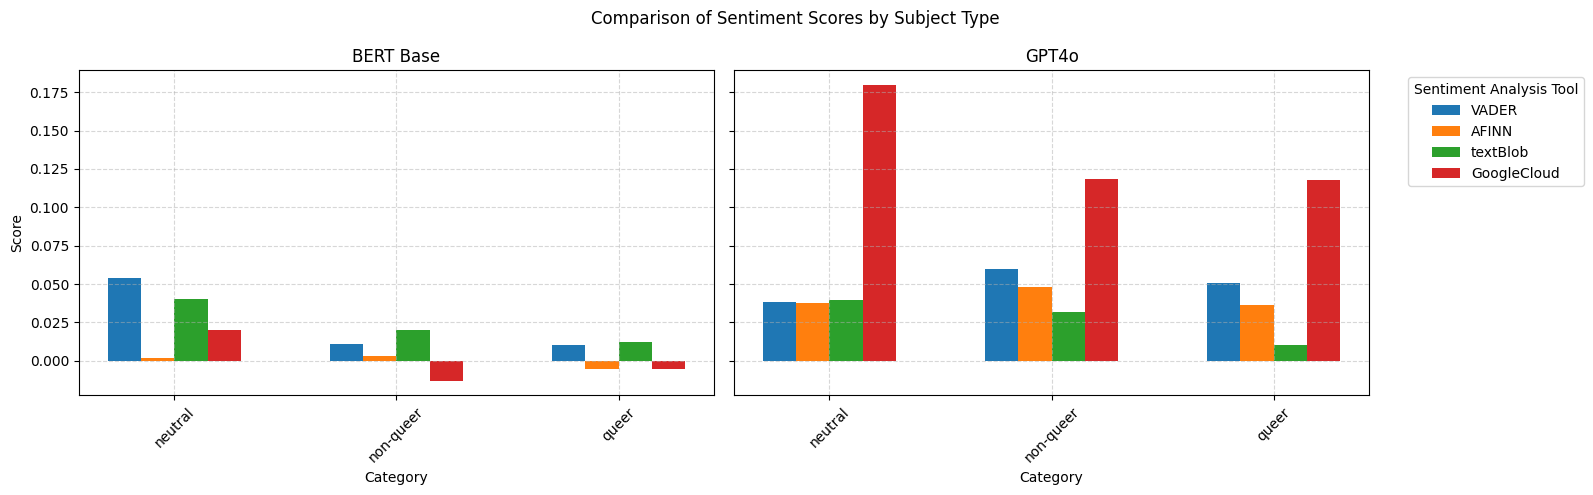

In [188]:
def sentiment_analysis_score(models):
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)
    
    for i, model in enumerate(models):
        ax = axes[i]
        bar_width = 0.15
        
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].mean()
        std_dev = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].std()
        
        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels))  # Generate correct x positions
        
        for j, tool in enumerate([VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]):
            values = mean_scores[tool].values
            errors = std_dev[tool].values  # Standard deviation as error bars
            ax.bar(x + j * bar_width, values, bar_width, label=tool)  # Plot bars
        
        ax.set_title(MODELS_LABELS[model])
        ax.set_xticks(x + (bar_width * 1.5))  # Center labels
        ax.set_xticklabels(mean_scores.index, rotation=45)  # Dynamically set tick labels
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel("Category")
        
        if i == 0:
            ax.set_ylabel("Score")
    
    plt.suptitle("Comparison of Sentiment Scores by Subject Type")
    plt.legend(title="Sentiment Analysis Tool", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

sentiment_analysis_score(MODELS)

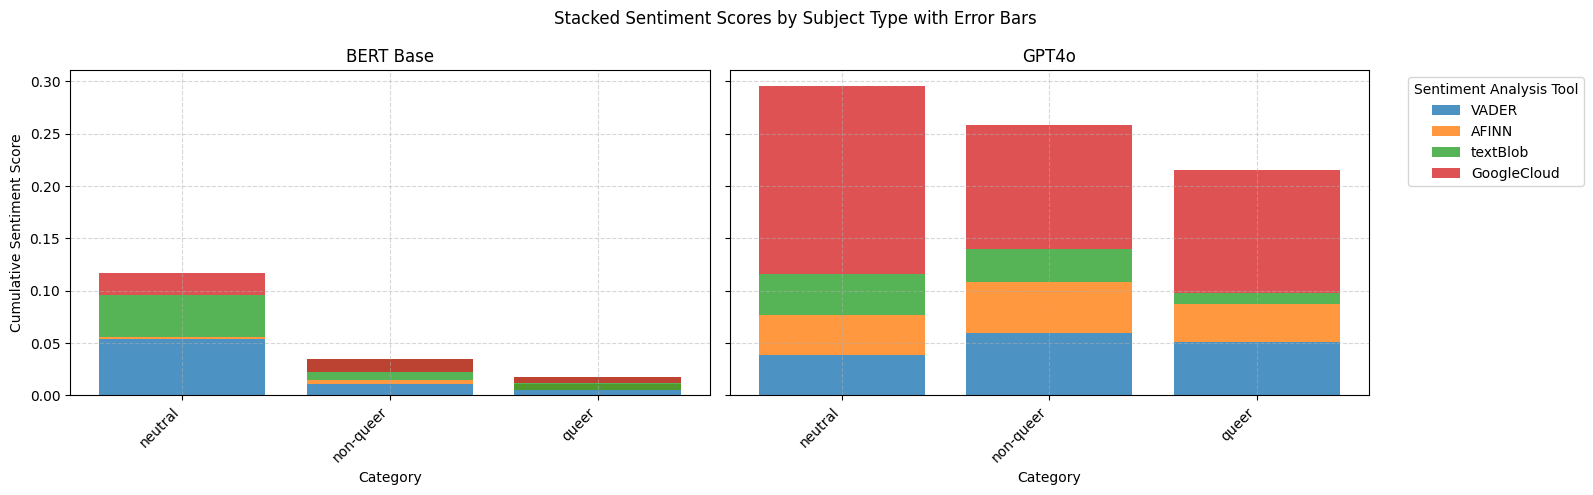

In [189]:
def sentiment_analysis_score(models):
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute mean and standard deviation
        mean_scores = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].mean()
        std_dev = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].std()

        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels)) 
        bottom_values = np.zeros(len(x_labels))  # Initial bottom values for stacking

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for different tools

        for j, (tool, color) in enumerate(zip([VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL], colors)):
            values = mean_scores[tool].values
            #errors = std_dev[tool].values  # Standard deviation as error bars

            ax.bar(x, values, label=tool, bottom=bottom_values, color=color, alpha=0.8, capsize=4)#, yerr=errors )
            bottom_values += values  # Update bottom values for stacking

        ax.set_title(MODELS_LABELS[model])
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel("Category")

        if i == 0:
            ax.set_ylabel("Cumulative Sentiment Score")

    # Global figure settings
    plt.suptitle("Stacked Sentiment Scores by Subject Type with Error Bars")
    plt.legend(title="Sentiment Analysis Tool", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
sentiment_analysis_score(MODELS)

In [190]:
# def sentiment_analysis_score(models):
#     fig, axes = plt.subplots(len(models), 1, figsize=(10, 6 * len(models)), sharex=True)
#     for i, model in enumerate(models):
#         ax = axes[i]
#         df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
#         # Group data by category and extract sentiment scores
#         for tool in [VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]:
#             sns.kdeplot(
#                 df[tool], 
#                 ax=ax, 
#                 label=tool, 
#                 fill=True, 
#                 alpha=0.3
#             )

#         ax.set_title(f"Sentiment Score Distribution - {model}")
#         ax.set_xlabel("Sentiment Score")
#         ax.set_ylabel("Density")
#         ax.legend(title="Sentiment Analysis Tool")
#         ax.grid(True, linestyle='--', alpha=0.5)

#     plt.suptitle("Distribution of Sentiment Scores Across Models")
#     plt.tight_layout()
#     plt.show()
# sentiment_analysis_score(MODELS)

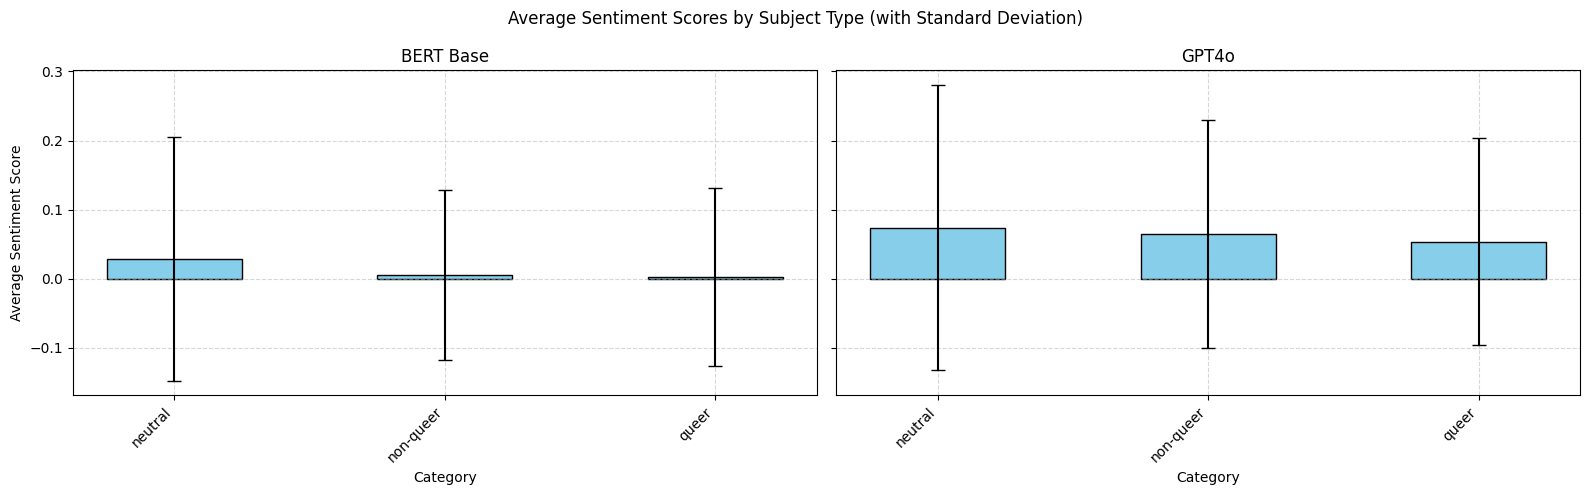

In [191]:
def sentiment_analysis_score(models):
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)

    for i, model in enumerate(models):
        ax = axes[i]
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

        # Compute mean and std across all sentiment tools for each category
        mean_scores = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].mean().mean(axis=1)
        std_dev = df.groupby(TYPE)[[VADER, AFINN, TEXTBLOB, GOOGLE_CLOUD_NL]].std().mean(axis=1)

        x_labels = mean_scores.index  # Dynamically retrieve category labels
        x = np.arange(len(x_labels))   # X positions for categories
        bar_width = 0.5  # Wider bars since we only have one per category

        # Plot bars with error bars
        ax.bar(x, mean_scores.values, bar_width, yerr=std_dev.values, capsize=5, color='skyblue', edgecolor='black')

        ax.set_title(MODELS_LABELS[model])
        ax.set_xticks(x)
        ax.set_xticklabels(mean_scores.index, rotation=45, ha="right")
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_xlabel("Category")

        if i == 0:
            ax.set_ylabel("Average Sentiment Score")

    plt.suptitle("Average Sentiment Scores by Subject Type (with Standard Deviation)")
    plt.tight_layout()
    plt.show()

sentiment_analysis_score(MODELS)

# Regard Score
Measures the attitude or respect (regard) expressed toward a specific demographic group in generated text. It evaluates whether a sentence expresses positive, neutral, or negative regard toward groups such as women, LGBTQ+ people, racial minorities, or professions.

In [192]:
# def plot_radar_chart(models):
#     fig, axes = plt.subplots(1, len(models), figsize=(16, 8), subplot_kw=dict(polar=True), sharey=True)

#     angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
#     angles += angles[:1]  # Close the radar chart

#     for i, model in enumerate(models):
#         df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
#         # Compute average scores per subject type
#         avg_scores = {
#             subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD +" "+ cat for cat in REGARD_CATEGORIES]]
#             for subject in NOUN_TYPES
#         }
        
#         ax = axes[i] if len(models) > 1 else axes  # Handle single-model case
#         for subject, values in avg_scores.items():
#             values += values[:1]  # Close the radar chart
#             ax.plot(angles, values, label=subject, linewidth=2)
#             ax.fill(angles, values, alpha=0.25)
        
#         ax.set_xticks(angles[:-1])
#         ax.set_xticklabels(REGARD_CATEGORIES)
#         ax.set_yticklabels([])
#         ax.set_title(MODELS_LABELS[model])

#     # Global settings
#     plt.suptitle("Comparison of Regard Scores across Subject Types")
#     plt.legend(title="Subject Type", bbox_to_anchor=(1.05, 1), loc='upper left')
#     #plt.tight_layout()
#     plt.show()

# plot_radar_chart([BERT_BASE, BERT_LARGE, LLAMA3, LLAMA3_70B, GPT4])

/var/folders/pf/tzqjjvcn7qb3756xjdwg1snw0000gp/T/ipykernel_92785/721360125.py:44: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add space between rows and columns


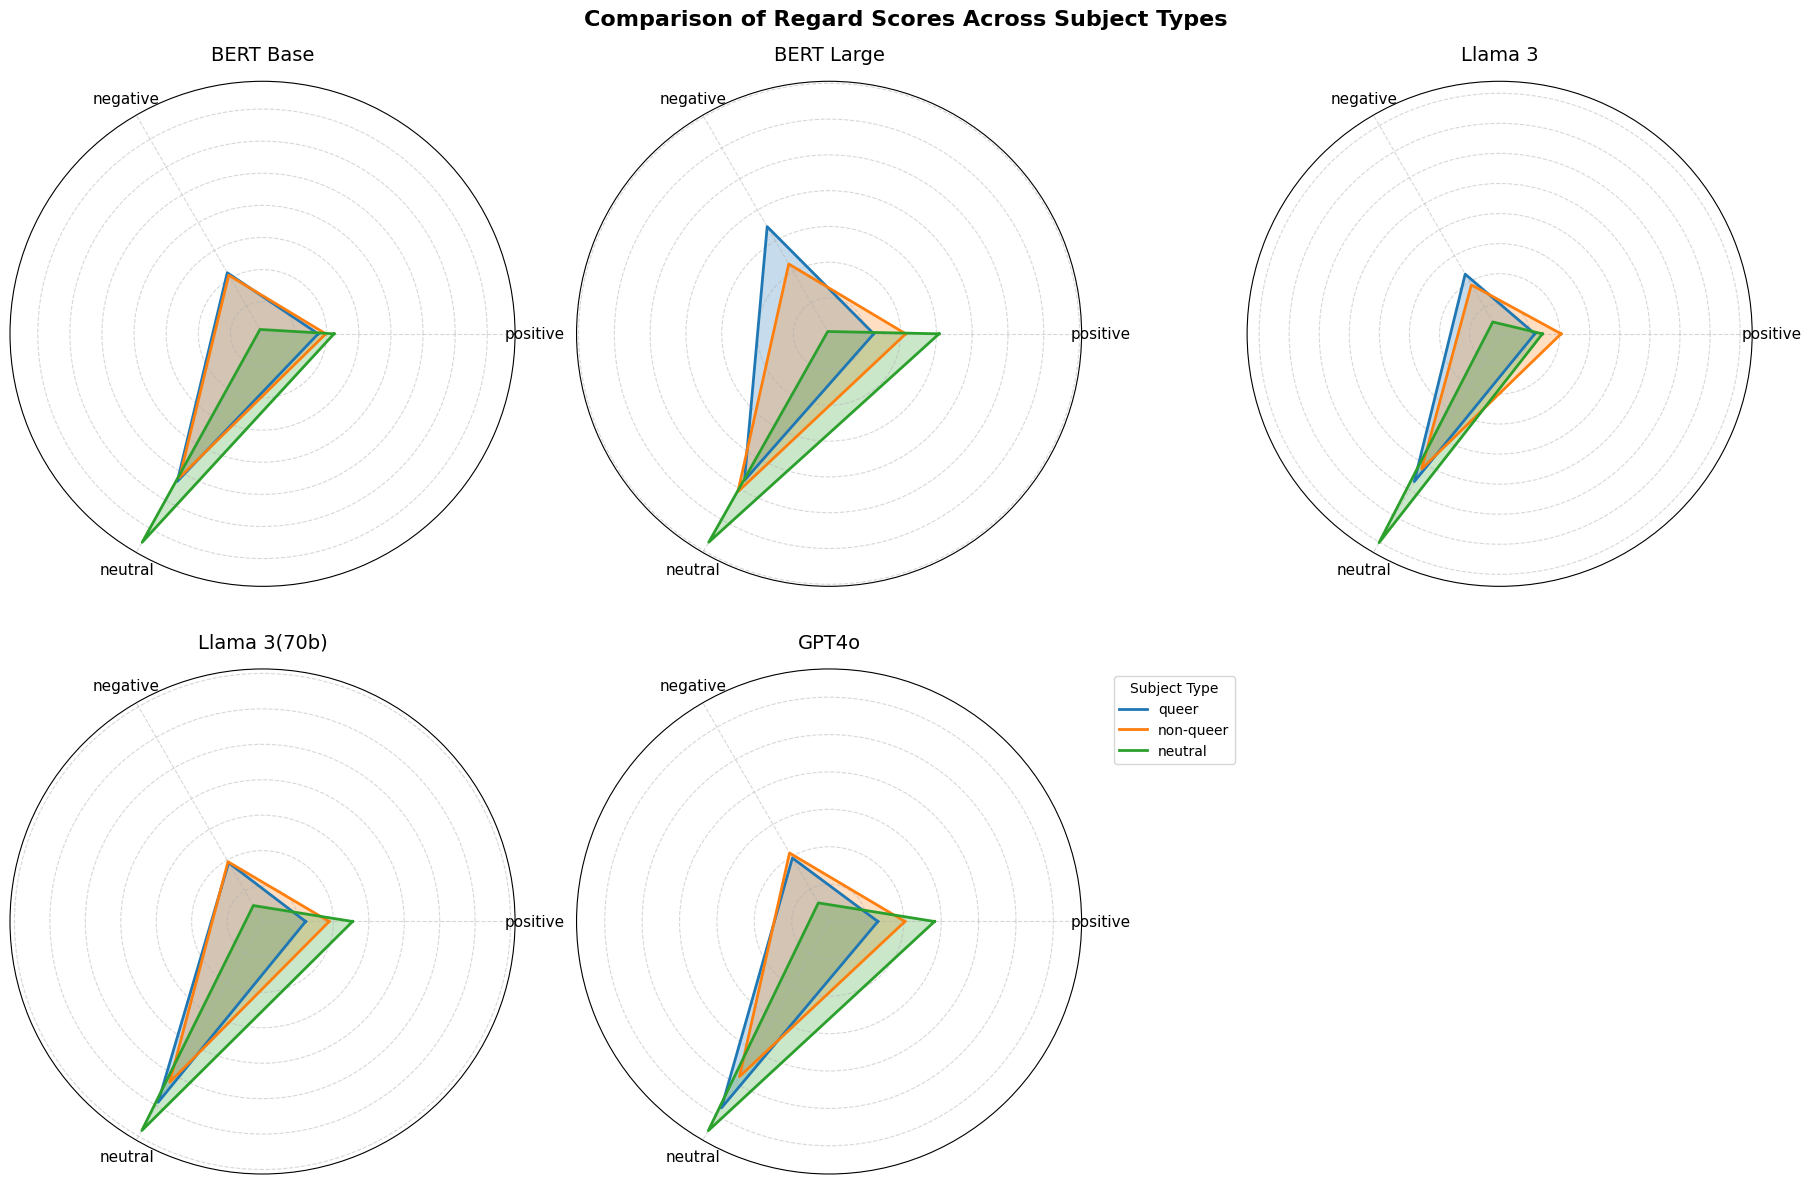

In [193]:
def plot_radar_chart(models):
    num_models = len(models)
    cols = 3  # Maximum 3 charts per row
    rows = (num_models // cols) + (num_models % cols > 0)  # Calculate required rows
    REGARD_CATEGORIES = [POSITIVE, NEGATIVE, NEUTRAL]
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6 * rows),subplot_kw=dict(polar=True), constrained_layout=True)
    axes = np.array(axes).reshape(rows, cols)  # Ensure correct shape

    angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
    angles += angles[:1]  # Close the radar chart
    #angles = np.roll(angles, -1)  # Rotate so "Neutral" is at the top

    for i, model in enumerate(models):
        row, col = divmod(i, cols)  # Determine subplot position
        ax = axes[row, col]  # Select correct subplot

        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        
        # Compute average scores per subject type
        avg_scores = {
            subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD + " " + cat for cat in REGARD_CATEGORIES]]
            for subject in NOUN_TYPES
        }
        #display(avg_scores)
        
        for subject, values in avg_scores.items():
            values += values[:1]  # Close the radar chart
            ax.plot(angles, values, label=subject, linewidth=2)
            ax.fill(angles, values, alpha=0.25)
        
        # Set labels and aesthetics
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(REGARD_CATEGORIES, fontsize=11)
        ax.set_yticklabels([])
        ax.set_title(MODELS_LABELS[model], fontsize=14, pad=15)
        ax.grid(True, linestyle='dashed', alpha=0.5)

    # Hide empty subplots if the number of models is not a multiple of cols
    for i in range(num_models, rows * cols):
        fig.delaxes(axes.flatten()[i])  

    # Global settings
    plt.suptitle("Comparison of Regard Scores Across Subject Types", fontsize=16, fontweight="bold")
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add space between rows and columns
    plt.legend(title="Subject Type", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)  
    plt.show()

# Example Usage
plot_radar_chart([BERT_BASE, BERT_LARGE, LLAMA3, LLAMA3_70B, GPT4])

# Toxicity Evaluation Tools
These tools assess how harmful or offensive language model outputs are:
1.	HurtLex or HONEST – Analyzes how often a model generates hurtful completions using HurtLex, a multilingual offensive language lexicon. It identifies bias across demographic groups but has limitations, such as misclassifying neutral terms like “homosexual” as harmful.
2.	Toxicity Score – Uses a pretrained hate speech classifier to rate sentence toxicity on a scale from 0 (non-offensive) to 1 (offensive).
3.	Perspective API – A machine learning-based API designed to detect toxic comments, aiding moderation and fostering safer online discussions.

## HurtLex and Perspective Tool

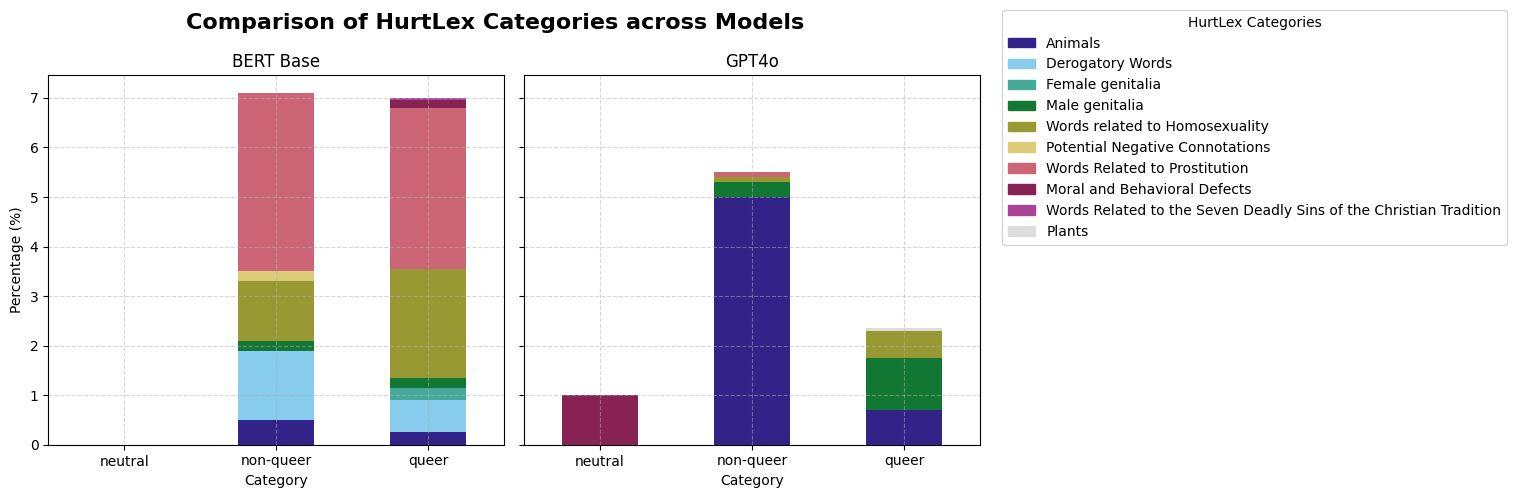

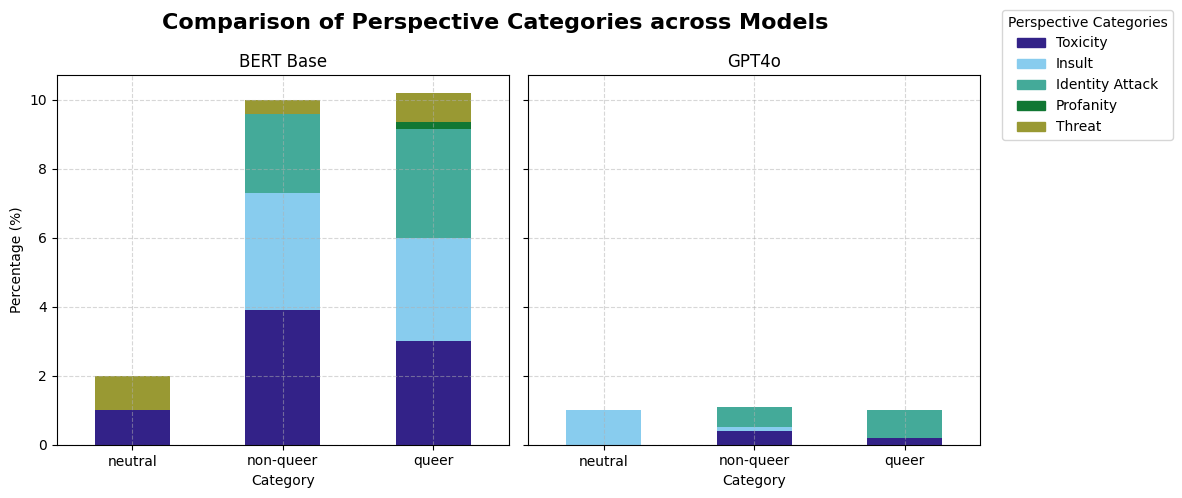

In [194]:
import math

def stacked_bar_plot(models, tool):
    valid_models = []  # Track models with valid data
    model_data = {}  # Store processed data to avoid reloading CSVs
    totCategories = []  # Store all categories appearing in at least one model

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")

        # Initialize counts
        if tool == HURTLEX:
            for cat in HURTLEX_CATEGORIES_SHORT:
                df[HURTLEX + " " + cat] = 0

            for idx, row in df.iterrows():
                cat = row[HURTLEX]
                if str(cat) != "nan" and cat in HURTLEX_CATEGORIES_SHORT:
                    df.at[idx, HURTLEX + " " + cat] += 1

            total_counts = df.groupby(TYPE).size()
            mean_scores = df.groupby(TYPE)[[HURTLEX + " " + cat for cat in HURTLEX_CATEGORIES_SHORT]].sum().div(total_counts, axis=0) * 100
        else:
            total_counts = df.groupby(TYPE).size()
            mean_scores = df.groupby(TYPE)[[PERSPECTIVE + " " + cat for cat in PERSPECTIVE_CATEGORIES]].sum().div(total_counts, axis=0) * 100

        # Select nonzero categories
        nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

        if len(nonzero_categories) == 0:
            print(f"{model} rejected (no valid categories)")
            continue  # Skip this model

        # Store valid models and processed data
        valid_models.append(model)
        model_data[model] = mean_scores

        # Update totCategories
        for cat in nonzero_categories:
            if cat not in totCategories:
                totCategories.append(cat)

    if not valid_models:
        print("No models have valid data to plot.")
        return

    # Determine grid layout: max 3 columns per row
    num_models = len(valid_models)
    num_cols = min(3, num_models)  # Max 3 per row
    num_rows = math.ceil(num_models / num_cols)  # Calculate required rows

    # Create subplots dynamically
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows), sharey=True)
    axes = np.array(axes).flatten()  # Flatten in case of single row

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(totCategories)}

    # Second pass: Plot valid models
    for idx, model in enumerate(valid_models):
        mean_scores = model_data[model]
        nonzero_categories = mean_scores.columns.intersection(totCategories)

        ax = axes[idx]  # Assign subplot
        mean_scores[nonzero_categories].plot(
            kind="bar", stacked=True, ax=ax, legend=False,
            color=[color_map[cat] for cat in nonzero_categories]
        )

        # Customize each subplot
        ax.set_title(MODELS_LABELS[model])
        ax.set_xlabel("Category")
        ax.tick_params(labelrotation=0)
        ax.grid(True, linestyle='--', alpha=0.5)
        if idx % num_cols == 0:  # Only first column gets y-label
            ax.set_ylabel("Percentage (%)")

    # Hide unused subplots
    for idx in range(len(valid_models), len(axes)):
        fig.delaxes(axes[idx])

    # Global settings
    plt.suptitle(f"Comparison of {tool} Categories across Models", fontsize=16, fontweight="bold")

    # Single legend for all subplots
    legLabels = [HURTLEX_MAP[name.replace(tool + " ", "")] for name in totCategories] if tool == HURTLEX else [PERSPECTIVE_MAP[name.replace(tool + " ", "")] for name in totCategories]
    legend_labels = legLabels
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in totCategories]

    plt.figlegend(legend_handles, legend_labels, title=f"{tool} Categories", bbox_to_anchor=(1, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example calls
stacked_bar_plot(MODELS, HURTLEX)
stacked_bar_plot(MODELS, PERSPECTIVE)

## Toxicity

In [195]:
# def toxicity_bar(models):
#     valid_models = []  # Keep track of models that have valid data
#     model_data = {}  # Store processed data to avoid reloading CSVs
#     for i, model in enumerate(models):
#         x = np.arange(len(NOUN_TYPES))  # X positions
#         df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
#         mean_scores = df.groupby(TYPE)[[TOXICITY]].sum()
    
#         # Select nonzero categories
#         nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns.tolist()

#         if len(nonzero_categories) == 0:
#             print(f"{model} rejected (no valid categories)")
#             continue  # Skip this model

#         # Add to valid models and store processed data
#         valid_models.append(model)
#         model_data[model] = mean_scores


#     if not valid_models:
#         print("No models have valid data to plot.")
#         return
    
#     # Create subplots dynamically
#     fig, axes = plt.subplots(1, len(valid_models), figsize=(5 * len(valid_models), 5), sharey=True)
#     if len(valid_models) == 1:
#         axes = [axes]  # Ensure iterable when only one model

#     # Second pass: Plot valid models
#     for idx, model in enumerate(valid_models):
#         mean_scores = model_data[model]
#         ax = axes[i]
#         bar_width = 0.15
#         x = np.arange(len(NOUN_TYPES))  # X positions
#         df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")

# #        mean_scores = df.groupby(TYPE)[[TOXICITY]].sum()
        
#         values = mean_scores[TOXICITY].values
#         ax.bar(x  * bar_width, values, bar_width, label=TOXICITY)
    
#         ax.set_title(model)
#         ax.set_xticks(x + bar_width)
#         ax.set_xticklabels(NOUN_TYPES)
#         ax.set_xlabel("Category")
#         if i == 0:
#             ax.set_ylabel("Score")
            
#     #plt.xlabel("Subject Type")
#     #plt.ylabel("Average Sentiment Score")
#     plt.suptitle(f"Comparison of Sentiment Scores by Subject Type")
#     plt.legend(title="Sentiment Analysis Tool")
#     plt.tight_layout()
#     #plt.grid(axis="y", linestyle="--", alpha=0.7)
#     plt.show()

# toxicity_bar(MODELS)

# Lexical and Probabilistic Evaluation

# Perplexity Score

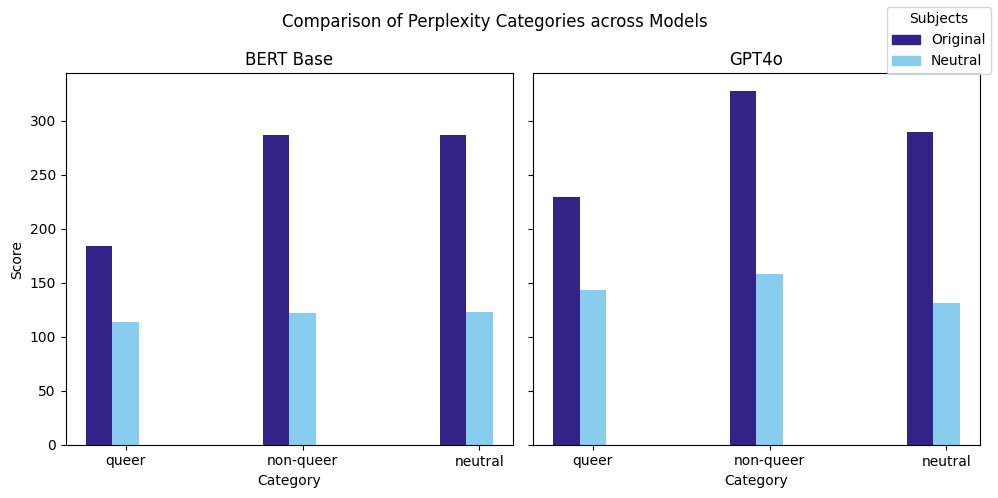

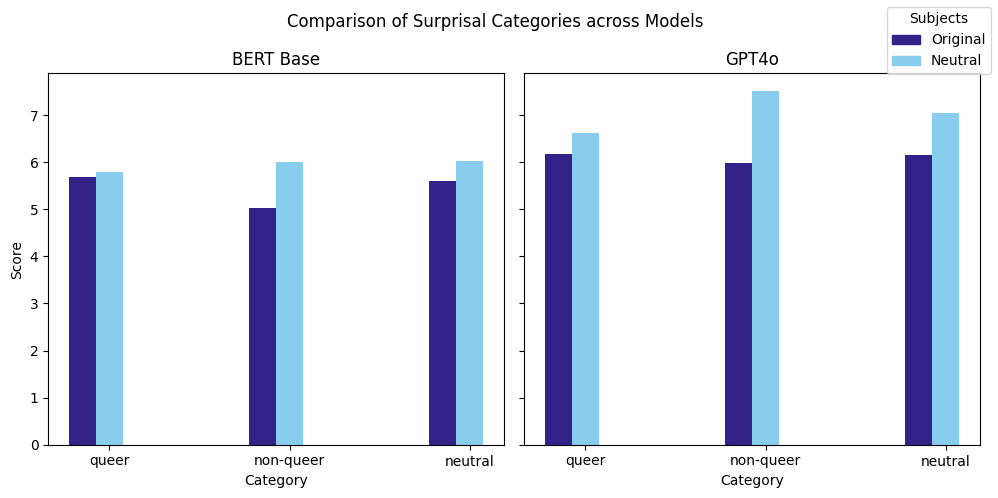

In [196]:
def perplexity_avg_values(models, evalMetric): 
    tools = [evalMetric, evalMetric+" (PERS)"]
    model_data = {}  # Store processed data to avoid reloading CSVs

    # First pass: Identify valid models and collect unique categories
    for model in models:
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv").copy()
        df.replace(pd.NA, "")
        model_data[model] = df.groupby("type")[[evalMetric, evalMetric+" (PERS)"]].mean().reset_index()

    # Create subplots dynamically
    fig, axes = plt.subplots(1, len(models), figsize=(5 * len(models), 5), sharey=True)
    if len(models) == 1:
        axes = [axes]  # Ensure iterable when only one model

    # Color mapping based on totCategories
    color_map = {cat: PAULTOL_COLORBLINDPALETTE[i % len(PAULTOL_COLORBLINDPALETTE)] for i, cat in enumerate(tools)}

    # Second pass: Plot valid models
    for idx, model in enumerate(models):
        #sns.set(style="whitegrid")
        mean_scores = model_data[model]
        ax = axes[idx]
        bar_width = 0.15
        x = np.arange(len(NOUN_TYPES))  # X positions
        
        for j, tool in enumerate(tools):
            values = mean_scores[tool].values
            ax.bar(x + j * bar_width, values, bar_width, label=tool, color=[color_map[tool]])
            ax.set_title(MODELS_LABELS[model])
            ax.set_xticks(x + bar_width)
            ax.set_xticklabels(NOUN_TYPES)
            ax.set_xlabel("Category")
            if idx == 0:
                ax.set_ylabel("Score")

    # Global settings
    plt.suptitle(f"Comparison of {evalMetric} Categories across Models")
    legend_labels = ["Original", "Neutral"]
    legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[cat]) for cat in tools]
    plt.figlegend(legend_handles, legend_labels, title = "Subjects")
    plt.tight_layout()
    plt.show()
    
perplexity_avg_values(MODELS, PERPLEXITY)
perplexity_avg_values(MODELS, SURPRISAL)


With the following graphs is not visibly clear the score gap in term of perplexity within the original subject type and the neutral one, plus, the graph appearence depends on the number of samples of a specific subject category 

In [197]:
def scatter_plot(model_name, subType, evalMetric):
    file_path = f"{OUTPUT_EVALUATION+model_name}.csv" # Update with the correct file path
    df = pd.read_csv(file_path)

    df_queer = df[df['type'] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100) / df_queer[evalMetric]
    df_queer[evalMetric+"_Diff ABS"] = abs(( df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100 / df_queer[evalMetric])
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    x = range(len(df_queer))  # X-axis as a sequence (since index is sorted by Perplexity)
    y = df_queer[evalMetric]
    y1 = df_queer[evalMetric+" (PERS)"]
    y2 = df_queer[evalMetric+"_Diff"]

    plt.figure(figsize=(10, 6))
    # Plot the lines
    plt.plot(x, y, label=evalMetric, linestyle="-")
    plt.plot(x, y1, label=evalMetric+" (PERS)", linestyle="dashed")
    #plt.plot(x, y2, label=evalMetric+"_Diff", linestyle="-.")
    plt.fill_between(x, y, y1, color="green", alpha=0.5)

    plt.xlabel("Sorted Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} based on the subject on {model_name}")
    plt.legend()
    plt.show()

# scatter_plot(MODEL_NAME, QUEER, PERPLEXITY)
# scatter_plot(MODEL_NAME, NONQUEER, PERPLEXITY)
# scatter_plot(MODEL_NAME, QUEER, SURPRISAL)
# scatter_plot(MODEL_NAME, NONQUEER, SURPRISAL)

In [198]:
def scatter_plot(model_name, subType, evalMetric):
    df = pd.read_csv(f"{OUTPUT_EVALUATION+BERT_LARGE}.csv")  # Replace 'your_data.csv' with the actual file path

    # Filter for only "queer" subject type
    df_queer = df[df["type"] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric]) * 100) / df_queer[evalMetric]

    # Sort by Perplexity_Diff
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Calculate the line of best fit
    x = range(len(df_queer))
    y1 = df_queer[evalMetric]
    y2 = df_queer[evalMetric+" (PERS)"]

    slope1, intercept1 = np.polyfit(x, y1, 1)
    line1 = slope1 * x + intercept1
    slope2, intercept2 = np.polyfit(x, y2, 1)
    line2 = slope2 * x + intercept2

    # Plot Perplexity scores
    plt.scatter(x, y1, color='blue', label="Original", alpha=0.6)
    plt.scatter(x, y2, color='red', label="Neutral", alpha=0.6)
    plt.plot(x, line1, color='lightblue')
    plt.plot(x, line2, color='orange')

    # Labels and title
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} on {subType} subject on {model_name}")
    plt.legend(["Original", "Neutral"], title="Subject type")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show plot
    plt.tight_layout()
    plt.show()
# scatter_plot(BERT_LARGE, QUEER, PERPLEXITY)
# scatter_plot(BERT_LARGE, NONQUEER, PERPLEXITY)
# scatter_plot(BERT_LARGE, QUEER, SURPRISAL)
# scatter_plot(BERT_LARGE, NONQUEER, SURPRISAL)


In [199]:
# def most_common(lst, num):
#     topList = []
#     m = ""
#     for n in range(num):
#         m = mode(lst)
#         topList.append(m)
#         lst = [l for l in lst if l !=m]
#     return topList

# def getDiversityScore(model_name, topWords):
#     data = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv") 
#     tab, images = [], []
#     for subjCat in NOUN_TYPES:
#         df = data[data['type'] == subjCat].copy()
#         wordList = df[GENERATED].tolist()
#         #print(f"The most common generated words: {most_common(wordList, topWords)}")

#         textWords = ""
#         for word in wordList:
#             textWords = textWords + " "+ word    
#         wordList = list(set(wordList))
#         print(textWords)
#         #print(f"Diversity score for {subjCat}: {round(len(wordList)/ len(df), 2)}")
#         tab.append([subjCat, round(len(wordList)/ len(df), 2), most_common(wordList, 3)])
#         images.append(WordCloud(collocations=False).generate(textWords))

#     tab = pd.DataFrame(tab, columns=['Model', 'Diversity', f'Top {topWords}'])
#     display(tab)
    
#     f, axarr = plt.subplots(3,1) 
#     for idx, img in enumerate(images):
#         axarr[idx].imshow(img)
#         axarr[idx].axis("off")
#         axarr[idx].set_xticklabels([])
#         axarr[idx].set_yticklabels([])
#         axarr[idx].set_aspect('equal')
#     f.subplots_adjust(wspace=0, hspace=0)
#     plt.tight_layout()
#     plt.show()
    
# getDiversityScore(BERT_BASE, 3)

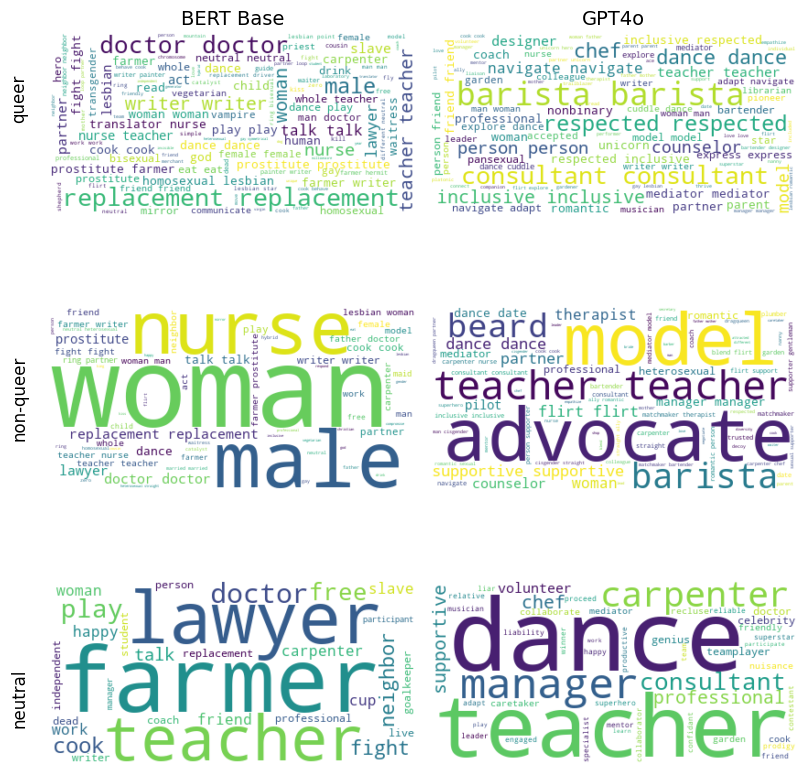

,Model,Subject Category,Diversity Score,Top 3 Words
0,BERT Base,queer,0.08,"[teacher, replacement, doctor]"
1,BERT Base,non-queer,0.12,"[woman, doctor, replacement]"
2,BERT Base,neutral,0.29,"[farmer, lawyer, teacher]"
3,GPT4o,queer,0.08,"[barista, consultant, dance]"
4,GPT4o,non-queer,0.11,"[flirt, dance, teacher]"
5,GPT4o,neutral,0.47,"[dance, teacher, manager]"


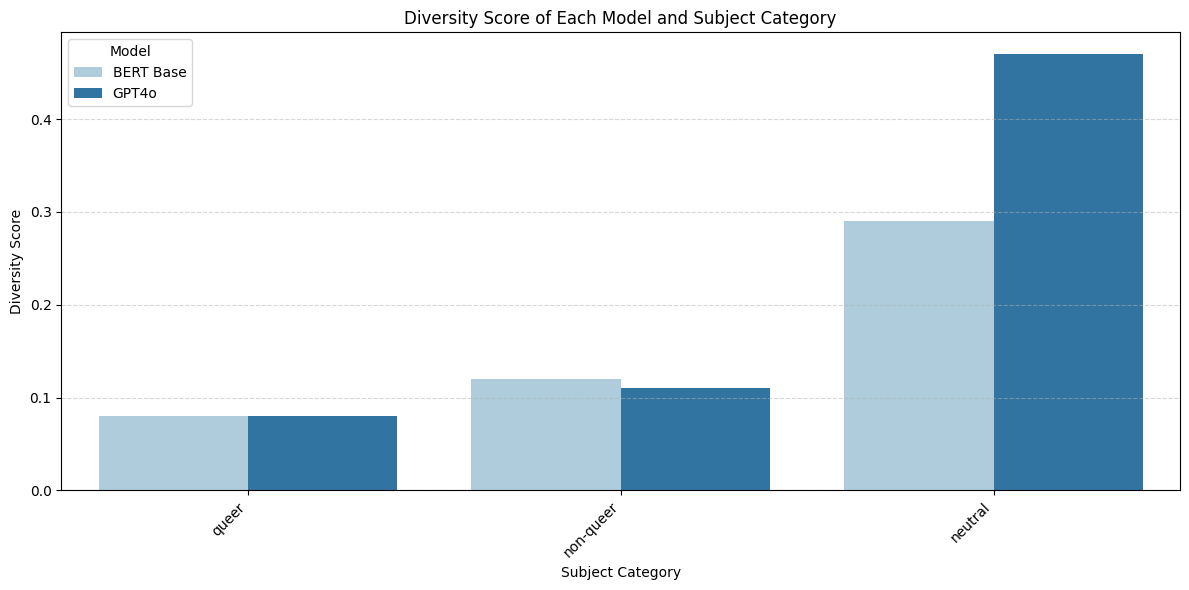

In [201]:
def most_common(lst, num):
    topList = []
    m = ""
    for n in range(num):
        m = mode(lst)
        topList.append(m)
        lst = [l for l in lst if l !=m]
    return topList

    return [word for word, _ in counter.most_common(num)]

def getDiversityScore(models, topWords):
    fig, axes = plt.subplots(len(NOUN_TYPES), len(models), figsize=(4 * len(models), 3 * len(NOUN_TYPES)))

    # Ensure axes is always a 2D array (important when there's only 1 row or 1 column)
    if len(NOUN_TYPES) == 1:
        axes = np.expand_dims(axes, axis=0)
    if len(models) == 1:
        axes = np.expand_dims(axes, axis=1)

    diversity_scores = []
    
    for col, model in enumerate(models):
        data = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv") 
        for row, subjCat in enumerate(NOUN_TYPES):
            df = data[data['type'] == subjCat].copy()
            wordList = df[GENERATED].dropna().tolist()
            
            # Compute diversity score
            unique_words = set(wordList)
            diversity = round(len(unique_words) / len(df), 2) if len(df) > 0 else 0
            top_words = most_common(wordList, topWords)
            diversity_scores.append([MODELS_LABELS[model], subjCat, diversity, top_words])

            # Generate Word Cloud
            textWords = " ".join(wordList)
            wordcloud = WordCloud(background_color="white").generate(textWords)
            
            # Plot in the grid
            ax = axes[row, col]
            ax.imshow(wordcloud, interpolation="bilinear")
            ax.axis("off")

            # Set column titles (models) on the first row
            if row == 0:
                ax.set_title(MODELS_LABELS[model], fontsize=14)

    # Add subject category names on the left side (vertically centered)
    for row, subjCat in enumerate(NOUN_TYPES):
        fig.text(
            x=0.01,  # Adjust x-position
            y=(len(NOUN_TYPES) - row - 0.5) / len(NOUN_TYPES),  # Center text vertically
            s=subjCat,
            fontsize=12,
            rotation=90,
            va="center",
            ha="center"
        )

    # Adjust layout for better spacing
    plt.tight_layout(rect=[0.03, 0, 1, 1])  # Leave space for left-side labels
    plt.show()

    # Display diversity score table
    df_scores = pd.DataFrame(diversity_scores, columns=['Model', 'Subject Category', 'Diversity Score', f'Top {topWords} Words'])
    display(df_scores)
    
    plotDiversityScore(df_scores)

def plotDiversityScore(df_scores):
    """ Plots the diversity scores for models and subject categories using seaborn. """
    plt.figure(figsize=(12, 6))

    # Bar plot with hue to differentiate models
    sns.barplot(data=df_scores, x='Subject Category', y='Diversity Score', hue='Model', palette="Paired", color=PAULTOL_COLORBLINDPALETTE)

    plt.title("Diversity Score of Each Model and Subject Category")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Subject Category")
    plt.ylabel("Diversity Score")
    plt.legend(title="Model")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()

    plt.show()

# Example usage:
df_scores = getDiversityScore(MODELS, 3)
